In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 120
# BATCH_SIZE = 100
LEARNING_RATE = 0.03
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [3]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset, train_and_validation, amount):
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, amount, replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [4]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)

assert not dataset.isnull().values.any()
#dataset['Amount'] = StandardScaler().fit_transform(dataset[['Amount']])
dataset = dataset.drop(['Amount'],axis=1)
#dataset['Hour'] = dataset['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
dataset = dataset.drop(['Time'],axis=1)
NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'
print(dataset.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...    0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ...   -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ...    0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952  ...   -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074  ...    0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.

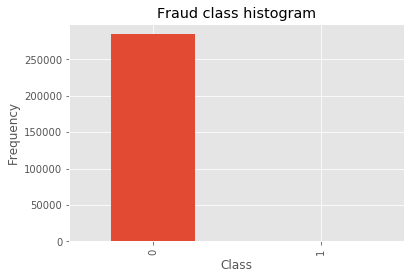

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [6]:
# Split dataset on train_and_validation dataset and test dataset
# train_and_validation, test = split_data(dataset, train_size=0.8)


In [7]:
# export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("..", "data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("..", "data", "test_dataset.data"), "wb" ))


In [8]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("..", "data", "train_and_validation_dataset.data"), "rb" ))


In [9]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_train, y_train, x_val=None, y_val=None, distinct = 0):
        print(x_train.shape, y_train.shape)
        tr = np.hstack((x_train, y_train))
        tr_f = tr[tr[:, -1] == 1]
        tr_n = tr[tr[:, -1] == 0]
        tr_f_ep = tr_f
        tr_n_ep = tr_n
        tr_score = np.concatenate((tr_f_ep, tr_n[: tr_f.shape[0],:]))
        #print("FIT: tyle jest frauds:", tr_f.shape)
        #print("FIT: tyle jest normals:", tr_n.shape)
        for i in range(self.epochs):
            if(distinct):
                tr_n = np.roll(tr_n, tr_f.shape[0])
                tr_n_ep = tr_n[: tr_f.shape[0],:]
                tr = np.concatenate((tr_f_ep, tr_n_ep))
                x_tr = tr[:,:-1]
                y_tr = tr[:,-1:]
                
            else:
                x_tr = x_train
                y_tr = y_train
                
            # zeby w kazdej epoce byly inne dobre i te same zle ( w jednej walidacji oczywiscie)
            
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.cumulative_gradient = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(tr_score[:,:-1], tr_score[:,-1:], x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [10]:
#Create array with only bad transactions for test&validation
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values

kfold_split_frauds = k_fold_split_data(fraud_indices, N_SPLITS)
kfold_split_frauds_lens = [len(x) for x in kfold_split_frauds]

normal_total = np.array(train_and_validation[train_and_validation.Class == 0].index)
normal_total_df = dataset.iloc[normal_total, :].sample(frac=1)
normal_total = normal_total_df.values
print(normal_total)

np.random.shuffle(normal_total)
normal_validation_indices = normal_total[:fraud_indices.shape[0], :]
normal_train = normal_total[fraud_indices.shape[0]:, :]

kfold_split_normals = k_fold_split_data(normal_validation_indices, N_SPLITS)

print(normal_train.shape, normal_validation_indices.shape, normal_total.shape)

# k-fold validation with k=5
models = []

[[  1.25539677e+00   2.12743727e-02  -1.13243701e-02 ...,  -2.68335728e-02
   -9.33177553e-03   0.00000000e+00]
 [ -1.50582683e-01   1.18432064e+00  -3.17141240e-01 ...,   3.01912628e-01
    1.23324180e-01   0.00000000e+00]
 [  2.27726062e+00  -1.61879223e+00  -2.36300252e+00 ...,   2.77170901e-02
   -5.68606071e-02   0.00000000e+00]
 ..., 
 [  1.46892767e+00  -1.01280055e+00  -1.74126684e+00 ...,  -7.00215686e-02
   -4.72048908e-02   0.00000000e+00]
 [  1.24502282e+00  -6.03633716e-01   1.75631742e-01 ...,   2.43069783e-03
    7.14548189e-03   0.00000000e+00]
 [ -8.24943982e+00   7.03180341e+00  -3.67406787e+00 ...,   9.56313339e-01
    7.39704230e-01   0.00000000e+00]]
(227065, 29) (390, 29) (227455, 29)


In [11]:
for k, validation_frauds in enumerate(kfold_split_frauds):
    #Get train frauds from train&validation frauds
    train_frauds = kfold_split_frauds.copy()
    train_frauds.pop(k)
    train_frauds = np.concatenate(train_frauds)
    print(len(train_frauds))
    
    validation_normals = kfold_split_normals[k]
    np.random.shuffle(normal_train)
    train_normals = normal_train[:train_frauds.shape[0]*EPOCHS,:]
    
    train = np.concatenate([train_frauds, train_normals])
    
    x_train = train[:, :-1]
    y_train = train[:, -1:]
    
    validation = np.concatenate([validation_frauds,validation_normals])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation, distinct=1)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)


312
(37752, 28) (37752, 1)
Loss:  0.19397403134  Accuracy:  0.6330128205128205
Loss:  0.181950937782  Accuracy:  0.6698717948717948
Loss:  0.175251709843  Accuracy:  0.6842948717948718
Loss:  0.168268983786  Accuracy:  0.7243589743589743
Loss:  0.160243226023  Accuracy:  0.7483974358974359
Loss:  0.154399963826  Accuracy:  0.7660256410256411
Loss:  0.151246448645  Accuracy:  0.7724358974358975
Loss:  0.14684246931  Accuracy:  0.782051282051282
Loss:  0.142879128395  Accuracy:  0.7948717948717948
Loss:  0.138532783981  Accuracy:  0.8060897435897436
Loss:  0.134484133227  Accuracy:  0.8205128205128205
Loss:  0.131618871449  Accuracy:  0.8301282051282052
Loss:  0.12880090802  Accuracy:  0.842948717948718
Loss:  0.125791088152  Accuracy:  0.8461538461538461
Loss:  0.123882607662  Accuracy:  0.8509615384615384
Loss:  0.121569196929  Accuracy:  0.8573717948717948
Loss:  0.118976066684  Accuracy:  0.8589743589743589
Loss:  0.117518479262  Accuracy:  0.8621794871794872
Loss:  0.116117052755  A

Loss:  0.0901866061936  Accuracy:  0.9198717948717948
Loss:  0.0892401937203  Accuracy:  0.9198717948717948
Loss:  0.0881700636998  Accuracy:  0.9230769230769231
Loss:  0.0870899609373  Accuracy:  0.9230769230769231
Loss:  0.0858318432081  Accuracy:  0.9246794871794872
Loss:  0.0851532167816  Accuracy:  0.9278846153846154
Loss:  0.0844010187262  Accuracy:  0.9278846153846154
Loss:  0.0839668395141  Accuracy:  0.9278846153846154
Loss:  0.0832492477238  Accuracy:  0.9310897435897436
Loss:  0.0823955019611  Accuracy:  0.9326923076923077
Loss:  0.0817533945491  Accuracy:  0.9326923076923077
Loss:  0.0808750816411  Accuracy:  0.9326923076923077
Loss:  0.0800958291862  Accuracy:  0.9310897435897436
Loss:  0.0794468420114  Accuracy:  0.9326923076923077
Loss:  0.0787973947094  Accuracy:  0.9358974358974359
Loss:  0.0787515146434  Accuracy:  0.9358974358974359
Loss:  0.0782487622805  Accuracy:  0.9391025641025641
Loss:  0.0777209155629  Accuracy:  0.9391025641025641
Loss:  0.077370890202  Accur

Loss:  0.0714584790525  Accuracy:  0.9358974358974359
Loss:  0.071259485591  Accuracy:  0.9358974358974359
Loss:  0.0708580041746  Accuracy:  0.9358974358974359
Loss:  0.0706646212885  Accuracy:  0.9358974358974359
Loss:  0.0705657064623  Accuracy:  0.9358974358974359
Loss:  0.070465340969  Accuracy:  0.9342948717948718
Loss:  0.0703339994431  Accuracy:  0.9358974358974359
Loss:  0.0701476832441  Accuracy:  0.9358974358974359
Loss:  0.069994062688  Accuracy:  0.9358974358974359
Loss:  0.0699004891696  Accuracy:  0.9375
Loss:  0.0697212856237  Accuracy:  0.9358974358974359
Loss:  0.0696188900392  Accuracy:  0.9358974358974359
Loss:  0.0694892024149  Accuracy:  0.9358974358974359
Loss:  0.0693518427102  Accuracy:  0.9358974358974359
Loss:  0.0693629450523  Accuracy:  0.9358974358974359
Loss:  0.0693072661196  Accuracy:  0.9358974358974359
Loss:  0.0691841007565  Accuracy:  0.9358974358974359
Loss:  0.0690412228071  Accuracy:  0.9358974358974359
Loss:  0.0688984512463  Accuracy:  0.9375
L

Loss:  0.0737961261119  Accuracy:  0.9278846153846154
Loss:  0.0738978186155  Accuracy:  0.9278846153846154
Loss:  0.0737789432826  Accuracy:  0.9278846153846154
Loss:  0.0738161675203  Accuracy:  0.9278846153846154
Loss:  0.0737405394758  Accuracy:  0.9294871794871795
Loss:  0.0736049518691  Accuracy:  0.9262820512820513
Loss:  0.0734878701228  Accuracy:  0.9262820512820513
Loss:  0.0733942736331  Accuracy:  0.9278846153846154
Loss:  0.0732843427133  Accuracy:  0.9262820512820513
Loss:  0.0732785340753  Accuracy:  0.9262820512820513
Loss:  0.0732049600779  Accuracy:  0.9262820512820513
Loss:  0.0731662838494  Accuracy:  0.9278846153846154
Loss:  0.0731156656802  Accuracy:  0.9278846153846154
Loss:  0.0730999279139  Accuracy:  0.9294871794871795
Loss:  0.0731078705541  Accuracy:  0.9278846153846154
Loss:  0.0730815444824  Accuracy:  0.9294871794871795
Loss:  0.0730428069337  Accuracy:  0.9294871794871795
Loss:  0.0729947665115  Accuracy:  0.9278846153846154
Loss:  0.0729953940734  Accu

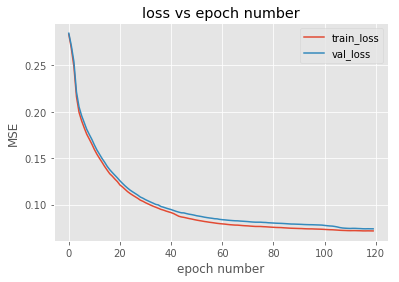

In [12]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [13]:
# Read test dataset
test = pickle.load(open(os.path.join("..", "data", "test_dataset.data"), "rb" ))

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

print("\nTest dataset evaluation:")
train_and_validation = train_and_validation.values 
x_train_and_validation = train_and_validation[:, :-1]
y_train_and_validation = train_and_validation[:, -1:]


Test dataset evaluation:


In [14]:
test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation, distinct=1)

(227845, 28) (227845, 1)
Loss:  0.242230535893  Accuracy:  0.6435897435897436
Loss:  0.172263122563  Accuracy:  0.7051282051282052
Loss:  0.165081684438  Accuracy:  0.7217948717948718
Loss:  0.158889719233  Accuracy:  0.7397435897435898
Loss:  0.153365466172  Accuracy:  0.7551282051282051
Loss:  0.148007005775  Accuracy:  0.7705128205128206
Loss:  0.142644360687  Accuracy:  0.7769230769230769
Loss:  0.137711753579  Accuracy:  0.7935897435897435
Loss:  0.133987862158  Accuracy:  0.8025641025641026
Loss:  0.129764389389  Accuracy:  0.8179487179487179
Loss:  0.125691198951  Accuracy:  0.8282051282051283
Loss:  0.122339795275  Accuracy:  0.8358974358974359
Loss:  0.120104770413  Accuracy:  0.8448717948717949
Loss:  0.117605999006  Accuracy:  0.8551282051282051
Loss:  0.115179986901  Accuracy:  0.8615384615384616
Loss:  0.113083337982  Accuracy:  0.8628205128205129
Loss:  0.110365250556  Accuracy:  0.867948717948718
Loss:  0.108240841968  Accuracy:  0.8743589743589744
Loss:  0.105971869032 

In [15]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss:  0.0698601400928
Accuracy:  0.9791439907306625

Precision: 0.056220095693779906
Recall: 0.9215686274509803
F-score: 0.10597519729425027


             actual 1  actual 0
predicted 1        94      1578
predicted 0         8     55282


100%|██████████| 21/21 [02:36<00:00,  7.44s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


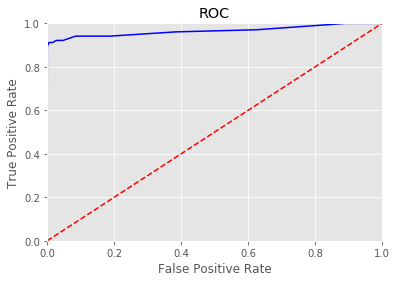

In [16]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)